In [1]:
# to measure run-time
import time

# to shuffle data
import random

# for plotting
import matplotlib.pyplot as plt

# pytorch stuff
import torch
import torch.nn as nn
import torch.optim as optim

# for csv dataset
import torchvision
import csv
import os
import pandas as pd 
from urllib import request
import requests

# import statements for iterating over csv file
import cv2
import numpy as np
import urllib.request

# to get the alphabet
import string

In [139]:
# Upload and read the csv files from the github repo
# change once get more data
df = pd.read_csv("https://raw.githubusercontent.com/HelenG123/aeye-alliance/master/Labelled%20Data/symbols_letters.csv")

In [17]:
# generate the targets 
# the targets are one hot encoding vectors

alphabet = list(string.ascii_lowercase)
target = {}

# Initalize a target dict that has letters as its keys and empty one-hot encoding vectors of size 37 as its values
for letter in alphabet: 
    target[letter] = [0] * 37

# Do the one-hot encoding for each letter now 
curr_pos = 0 
for curr_letter in target.keys():
    target[curr_letter][curr_pos] = 1
    curr_pos += 1  

# extra symbols 
symbols = [' ', '#', '.', ',', ':', '\'', '-', ';', '?', '!', 'CAPS']

# create vectors
for curr_symbol in symbols:
    target[curr_symbol] = [0] * 37

# create one-hot encoding vectors
for curr_symbol in symbols:
    target[curr_symbol][curr_pos] = 1
    curr_pos += 1

print(target)

{'a': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'b': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'c': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'd': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'e': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'f': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'g': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'h': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'i': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

In [140]:
# collect all data from the csv file
data=[]

# iterate over csv file
for i, row in df.iterrows():
    # store the image and label
    picture = []
    url = row['Labeled Data']
    label = row['Label']
    curr_target = target[label[11]]
    x = urllib.request.urlopen(url)
    resp = x.read()
    image = np.array(bytearray(resp), dtype=np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    # resize image to 28x28x3
    image = cv2.resize(image, (28, 28))
    # normalize to 0-1
    image = image.astype(np.float32)/255.0
    image = torch.from_numpy(image)
    picture.append(image)
    # convert the target to a long tensor
    curr_target=torch.LongTensor([curr_target])
    picture.append(curr_target)
    # append the current image & target
    data.append(picture)

In [141]:
# create a dictionary of all the characters 
characters = alphabet + symbols

index2char = {}
number = 0
for char in characters: 
    index2char[number] = char
    number += 1

print(index2char)

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z', 26: ' ', 27: '#', 28: '.', 29: ',', 30: ':', 31: "'", 32: '-', 33: ';', 34: '?', 35: '!', 36: 'CAPS'}


In [142]:
# find the number of each character in a dataset
def num_chars(dataset, index2char):
    chars = {}
    for _, label in dataset:
        char = index2char[int(torch.argmax(label))]
        # update
        if char in chars:
            chars[char] += 1
        # initialize
        else:
            chars[char] = 1
    return chars

In [225]:
# Create dataloader objects

# shuffle all the data
random.shuffle(data)

# batch sizes for train, test, and validation
batch_size_train = 10
batch_size_test = 3
batch_size_validation = 3

# 2121
# splitting data to get training, test, and validation sets
# change once get more data
# 1600 for train
train_dataset = data[:1697]
# test has 212
test_dataset = data[1697:1909]
# validation has 212
validation_dataset = data[1909:]

# create the dataloader objects
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size_test, shuffle=False)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size_validation, shuffle=True)

print(len(train_loader))
print(len(test_loader))
print(len(validation_loader))

170
71
71


In [226]:
print(len(num_chars(test_dataset, index2char)))
print(num_chars(test_dataset, index2char))

36
{'!': 5, 'x': 7, 'j': 7, ' ': 1, 't': 11, 'o': 5, ':': 8, ',': 6, 'e': 10, 'q': 7, 'i': 7, 'n': 3, '-': 3, '#': 9, 'b': 7, 'a': 6, 'g': 8, '.': 6, 'p': 10, 'k': 2, '?': 4, 'h': 7, 'd': 11, 'f': 9, 'c': 4, 'u': 7, 'l': 7, 'r': 8, 'y': 3, "'": 4, 's': 4, 'w': 4, ';': 4, 'z': 4, 'm': 2, 'v': 2}


In [227]:
# to check if a dataset is missing a char
test_chars = num_chars(test_dataset, index2char)

num = 0
for char in characters:
    if char in test_chars:
        num += 1
    else:
        break
print(num) 

36


In [228]:
# defines the convolutional neural network

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.block1 = nn.Sequential(
            #3x28x28
            nn.Conv2d(in_channels=3, 
                      out_channels=16, 
                      kernel_size=5, 
                      stride=1, 
                      padding=2),
            # batch normalization
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True), 
            #16x28x28
            nn.MaxPool2d(kernel_size=2),
            #16x14x14
            nn.LeakyReLU()
        )
        #16x14x14
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=16, 
                      out_channels=32, 
                      kernel_size=5, 
                      stride=1, 
                      padding=2),
            # batch normalization
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True), 
            #32x14x14
            nn.MaxPool2d(kernel_size=2),
            #32x7x7
            nn.LeakyReLU()
        ) 
        # linearly 
        self.block3 = nn.Sequential(
            nn.Linear(32*7*7, 100),
            # batch normalization
            nn.BatchNorm1d(100),
            nn.LeakyReLU(),
            nn.Linear(100, 37)
        )
        #1x37
    
    def forward(self, x): 
        out = self.block1(x)
        out = self.block2(out)
        # flatten the dataset
        out = out.view(-1, 32*7*7)
        out = self.block3(out)
        
        return out

# convolutional neural network model
model = CNN()

# print summary of the neural network model to check if everything is fine. 
print(model)
print("# parameter: ", sum([param.nelement() for param in model.parameters()]))

CNN(
  (block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (block3): Sequential(
    (0): Linear(in_features=1568, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=100, out_features=37, bias=True)
  )
)
# parameter:  174981


In [229]:
# setting the learning rate
learning_rate = 2e-4

# Using a variable to store the cross entropy method
criterion = nn.CrossEntropyLoss()

# Using a variable to store the optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [230]:
t0 = time.time()

# list of all train_losses 
train_losses = []

# list of all validation losses 
validation_losses = []

# for loop that iterates over all the epochs
num_epochs = 20
for epoch in range(num_epochs):
    
    # variables to store/keep track of the loss and number of iterations
    train_loss = 0
    num_iter_train = 0

    # train the model
    model.train()
    
    # Iterate over train_loader
    for i, (images, labels) in enumerate(train_loader):  
        # need to permute so that the images are of size 3x28x28 
        # essential to be able to feed images into the model
        images = images.permute(0, 3, 1, 2)

        # Zero the gradient buffer
        # resets the gradient after each epoch so that the gradients don't add up
        optimizer.zero_grad()  

        # Forward, get output
        outputs = model(images)
        
        # convert the labels from one hot encoding vectors into integer values 
        labels = labels.view(-1, 37)
        y_true = torch.argmax(labels, 1)

        # calculate training loss
        loss = criterion(outputs, y_true)
        
        # Backward (computes all the gradients)
        loss.backward()
        
        # Optimize
        # loops through all parameters and updates weights by using the gradients 
        # takes steps backwards to optimize (to reach the minimum weight)
        optimizer.step()
        # update the training loss and number of iterations
        train_loss += loss.data[0]
        num_iter_train += 1

    print('Epoch: {}'.format(epoch+1))
    print('Training Loss: {:.4f}'.format(train_loss/num_iter_train))
    # append training loss over all the epochs
    train_losses.append(train_loss/num_iter_train)

    # evaluate the model
    model.eval()
    
    # variables to store/keep track of the loss and number of iterations
    validation_loss = 0
    num_iter_validation = 0
    
    # Iterate over validation_loader
    for i, (images, labels) in enumerate(validation_loader):  
        # need to permute so that the images are of size 3x28x28 
        # essential to be able to feed images into the model
        images = images.permute(0, 3, 1, 2)

        # Forward, get output
        outputs = model(images)

        # convert the labels from one hot encoding vectors to integer values
        labels = labels.view(-1, 37)
        y_true = torch.argmax(labels, 1)
        
        # calculate the validation loss
        loss = criterion(outputs, y_true)

        # update the training loss and number of iterations
        validation_loss += loss.data[0]
        num_iter_validation += 1

    print('Validation Loss: {:.4f}'.format(validation_loss/num_iter_validation))
    # append all validation_losses over all the epochs
    validation_losses.append(validation_loss/num_iter_validation)

    num_iter_test = 0
    correct = 0
    
    # Iterate over test_loader
    for images, labels in test_loader:  

        # need to permute so that the images are of size 3x28x28 
        # essential to be able to feed images into the model
        images = images.permute(0, 3, 1, 2)

        # Forward
        outputs = model(images)

        # convert the labels from one hot encoding vectors into integer values 
        labels = labels.view(-1, 37)
        y_true = torch.argmax(labels, 1)

        # find the index of the prediction
        y_pred = torch.argmax(outputs, 1).type('torch.FloatTensor')
        
        # convert to FloatTensor
        y_true = y_true.type('torch.FloatTensor')

        # find the mean difference of the comparisons
        correct += torch.sum(torch.eq(y_true, y_pred).type('torch.FloatTensor'))

    print('Accuracy on the test set: {:.4f}%'.format(correct/len(test_dataset) * 100))
    print()

# calculate time it took to train the model
tf = time.time()
print()
print("time: {} s" .format(tf-t0))

/home/tingyisu/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1
Training Loss: 3.4754
Validation Loss: 3.3249
Accuracy on the test set: 25.4717%



/home/tingyisu/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:80: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 2
Training Loss: 3.1161
Validation Loss: 2.9808
Accuracy on the test set: 57.0755%

Epoch: 3
Training Loss: 2.7828
Validation Loss: 2.5817
Accuracy on the test set: 54.7170%

Epoch: 4
Training Loss: 2.4420
Validation Loss: 2.3241
Accuracy on the test set: 67.4528%

Epoch: 5
Training Loss: 2.0823
Validation Loss: 2.1904
Accuracy on the test set: 79.7170%

Epoch: 6
Training Loss: 1.7578
Validation Loss: 1.5924
Accuracy on the test set: 75.9434%

Epoch: 7
Training Loss: 1.4621
Validation Loss: 1.3991
Accuracy on the test set: 90.5660%

Epoch: 8
Training Loss: 1.1975
Validation Loss: 0.9423
Accuracy on the test set: 88.6792%

Epoch: 9
Training Loss: 0.9992
Validation Loss: 1.0055
Accuracy on the test set: 91.9811%

Epoch: 10
Training Loss: 0.8309
Validation Loss: 0.9985
Accuracy on the test set: 84.4340%

Epoch: 11
Training Loss: 0.6769
Validation Loss: 0.6331
Accuracy on the test set: 93.3962%

Epoch: 12
Training Loss: 0.6020
Validation Loss: 0.5438
Accuracy on the test set: 94.811

In [188]:
# learning curve function
def plot_learning_curve(train_losses, validation_losses):
    # plot the training and validation losses
    plt.ylabel('Loss')
    plt.xlabel('Number of Epochs')
    plt.plot(train_losses, label="training")
    plt.plot(validation_losses, label="validation")
    plt.legend(loc=1)

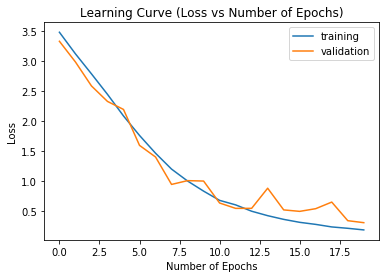

In [231]:
# plot the learning curve
plt.title("Learning Curve (Loss vs Number of Epochs)")
plot_learning_curve(train_losses, validation_losses)